# Error propagation with MCMC

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import numba
# Library to perform MCMC runs
import emcee

# Import the project utils
import sys
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

In our first parameter estimation [using MCMC](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/MCMC_parameter_estimation.ipynb) we reported a credible region for the MWC parameters and the fold-change based on the data and the fit to the model. But these estimates didn't include previous characterized uncertainty in the parameters of the model.

For example at the time we computed the fold-chage for each of the RBS mutants we assumed we knew with 100% certainty the mean repressor copy number. This assumption is far from the truth since in their paper [Garcia and Phillips](http://www.pnas.org/content/108/29/12173.abstract) report the mean $\pm$ standard deviation of the repressor copy number as revealed by multiple measurements of these quantities. The same applies to the repressor binding energies.

The question then becomes how do we include these sources of uncertainty into our fold-change model with induction?

## Bayes theorem as a method for learning

The Bayesian framework gives a natural form on how to solve this issue. Let's focus first on the uncertainty of the repressor. We could write our parameter estimation using Bayes theorem as

\begin{equation}
P(\epsilon_A, \epsilon_I, R \mid D, I) \propto P(D \mid \epsilon_A, \epsilon_I, R, I) \cdot P(\epsilon_A, \epsilon_I, R \mid I),
\end{equation}

where we explicitly included the dependence on the repressor copy number. The second term on the right hand side, the so-called prior, **includes all the information we know before performing the experiment**. For simplicity we can assume that the parameters are independent such that we can rewrite this term as

\begin{equation}
P(\epsilon_A, \epsilon_I, R \mid I) = P(\epsilon_A \mid I) \cdot P(\epsilon_I \mid I) \cdot P(R \mid I).
\end{equation}

Usually one doesn't want to bias the inference with the prior, therefore we are train to use *maximally uniformative priors* for the parameters. So for our previous model we chose a uniform prior for the $\epsilon_A$ and $\epsilon_I$ parameteres, i.e.

\begin{align}
P(\epsilon_A \mid I) &\propto \frac{1}{\epsilon_{A_\max} - \epsilon_{A_\min}}, \\
P(\epsilon_I \mid I) &\propto \frac{1}{\epsilon_{I_\max} - \epsilon_{I_\min}}, \\
\end{align}

But in a sense Bayes theorem is a *model for learning*. What we mean with that is that it naturally allows us to update our parameter estimates after performing an experiment and obtaining data. So in the case when one doesn't know anything at all about the parameter value these uniformative priors are the right thing to use. Now, what happens when one does indeed have information about the value of some of these parameters from previous experiments? Well, then that prior information should be included in the prior!

### Prior on the parameters to include sources of uncertainty

For the term $P(R \mid I)$ we should include the characterized uncertainty that Garcia and Phillips reported in their paper. Quoting the paper it reads
> Immunoblots were used to measure the number of Lac repressors in six strains with different constitutive levels of Lac repressor. Each value corresponds to an average of cultures grown on at least 3 different days. The error bars are the SD of these measurements.

This means that the number they report is the *mean repressor copy number* and the *standard deviation on these measurements*. It is important to clarify that this standard deviation **does not** reflect the single-cell variability of repressors, but the experimental uncertainty when measuring the mean repressor copy number. In other words this standard deviation captures the lack of perfect accuracy when measuring this parameter, not the natural biological noise one expects on a clonal population.

The repressor copy number per cell itself is a *discrete variable*, therefore one could naively think that the prior should be therefore given by a discrete distribution. But we should recall that what Garcia and Phillips measured with their immunoblots was not a single cell measurement, but a bulk measurement where they got to measure the **mean repressor copy number** which is not a discrete variable itself. As a matter of fact by the central limit theorem we know that we expect the distribution of the mean repressor copy number to be Gaussian. Therefore we can write

\begin{equation}
P(R \mid \sigma_R, I) \approx \frac{1}{\sqrt{2 \pi \sigma_R^2}}\exp \left[ \frac{(R - R^*)^2}{2 \sigma_R^2}  \right] \; \forall R > 0,
\end{equation}

where $\sigma_R$ is the characterized standard deviation that Garcia and Phillips experimentally characterized for each RBS mutant, and $R^*$ is the mean repressor level also characterized experimentally.

If we include this prior for the repressor copy number and an equivalent one for the repressor binding energy, and allow the MCMC walkers to walk on these two new dimensions while fitting the MWC parameters, then the posterior probability for the fold-change would include all of the characterized uncertainty on the parameters! In this way we can properly build the credible region for our predictions.

### The log posterior probability

Including the uncertainty on the mean repressor copy number and the binding energy implies that our posterior is now of the form

\begin{equation}
P(\epsilon_A, \epsilon_I, R_i, \epsilon_{r_j} \mid fc_{\exp_{ijk}}, R_i^*, \sigma_{R_i}, \epsilon_{r_j}^*, \sigma_{\epsilon_{r_j}}, C_k, I) \propto \prod_i \prod_j \prod_k P(fc_{\exp_{ijk}} \mid \epsilon_A, \epsilon_I, R_i, \epsilon_{r_j}, R_i^*, \sigma_{R_i}, \epsilon_{r_j}^*, \sigma_{\epsilon_{r_j}}, C_k, I) \cdot P(\epsilon_A \mid C_k, I) \cdot P(\epsilon_I \mid C_k, I) \cdot P(R_i \mid R_i^* \sigma_{R_i}, C_k, I) \cdot P(\epsilon_{r_j} \mid \epsilon_{r_j}^*, \sigma_{\epsilon_{r_j}}, C_k, I),
\end{equation}

where the subindex $i$ lists all the RBS mutants, the subindex $j$ lists all the operators, and the subindex $k$ lists all the IPTG concentrations $C$. $fc_{\exp_{ijk}}$ represents the experimentally determined fold-change.

This form of the posterior means that the parameter estimation will be done over the two MWC parameters, however many RBS mutants are included and also however many operators. The independent variables now become:
1. The IPTG concentration.
2. The experimental mean repressor copy number.
3. The experimental standard deviation on the repressor copy number.
4. The experimental mean repressor binding energy.
5. the experimental standard deviation on the repressor binding enery.

The function functional form of the log posterior probability assuming as before a Gaussian distribution of the residuals is of the form

\begin{equation}
\ln P(\epsilon_A, \epsilon_I, R_i, \epsilon_{r_j} \mid fc_{\exp_{ijk}}, R_i^*, \sigma_{R_i}, \epsilon_{r_j}^*, \sigma_{\epsilon_{r_j}}, C_k, \sigma, I) \propto - (n + 1) \ln \sigma + \sum_i \sum_j \sum_k  - \frac{1}{2 \sigma^2} \left(fc_{\exp_{ijk}} - fc(\epsilon_A, \epsilon_I, R_i, \epsilon_{r_j}, C_k) \right)^2 - \frac{\left( R_i - R_i^* \right)^2}{2 \sigma^2_{R_i}} - \frac{\left( \epsilon_{r_j} - \epsilon_{r_j}^* \right)^2}{2 \sigma^2_{\epsilon_{r_j}}} ,
\end{equation}

where $n$ is the total number of data points.

In order to minimize the data frame parsing that the log-posterior has to do when performing the MCMC let's write a pre-processing function that will parse the data once such that the output can be feed to the log-posterior function.

In [2]:
def mcmc_pre_process(df):
    """
    Pre-process the tidy DataFrame to prepare it for the MCMC. This is done
    separately from the log-posterior calculation to speed up the process
    avoiding parsing the DataFrame every evaluation of the posterior.
    Parameteres
    -----------
    df : pandas DataFrame.
        A tidy pandas DataFrame as standardized in the project that contains
        at least the following columns:
        fold_change_A : the experimental fold-change from channel A in the
        flow cytometer.
        IPTG_uM : uM concentrations of the inducer
        repressors : the mean repressor copy number
        delta_repressors : the experimental SD on the mean repressor copy number
        binding_energy : the mean repressor binding energy
        delta_energy : the experimental SD on the binding energy

    Returns
    -------
    [rep_unique, eps_unique] : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    """
    # List the unique variables
    rep_unique = np.sort(df.repressors.unique())
    eps_unique = np.sort(df.binding_energy.unique())
    IPTG_unique = np.sort(df.IPTG_uM.unique())
    
    # determine the number of unique variables
    n_repressor = len(rep_unique)
    n_epsilon_r = len(eps_unique)
    n_IPTG = len(IPTG_unique)
    
    # Depending on the number of parameters determine the indexes of the
    # parameters to fit
    param_idx = np.cumsum([3, n_repressor, n_epsilon_r])
    
    # Sort the data frame such that the log-posterior function can
    # automatically compute the log probability with the right parameters
    # for each data point
    df_sort = df.sort(['repressors', 'binding_energy', 'IPTG_uM'])
    data = np.array(df_sort[['fold_change_A', 'IPTG_uM', 
                             'repressors', 'delta_repressors', 
                             'binding_energy', 'delta_energy']])
    return [rep_unique, eps_unique], param_idx, data

Now let's define the function to compute the likelihood, the prior and the posterior probability

In [3]:
def log_likelihood(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log likelihood probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = param[param_idx[1]:param_idx[2]] # Represor energies
   
    # Initialize the log_likelihood
    log_like = 0
    # loop through the parameters to fit in order to compute the
    # theoretical fold change using the right parameters for each strain
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 4]==eps), :]
            # compute the theoretical fold-change
            fc_theory = mwc.fold_change_log(data_block[:, 1],
                                            ea, ei, epsilon,
                                            rep[i], eps_r[j])
            # compute the log likelihood for this block of data
            log_like -=  np.sum((fc_theory - data_block[:, 0])**2) / 2 / sigma**2
            
    return log_like

def log_prior(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-prior probability
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log prior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = param[param_idx[1]:param_idx[2]] # Represor energies
    
    # Initialize the log_prior
    log_prior = 0
    # loop through the parameters to to fit in order to compute the appropiate
    # log prior
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 4]==eps), :]
            log_prior -= np.sum((rep[i] - data_block[:, 2])**2 / \
                         2 / data_block[:, 3]**2)
            log_prior -= np.sum((eps_r[j] - data_block[:, 4])**2 / \
                         2 / data_block[:, 5]**2)
                
    # check the bounds on the parameterreps
    if np.any(rep <= 0) or (sigma <= 0):
        return -np.inf
    
    return log_prior

def log_post(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    The log posterior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_r = param[param_idx[1]:param_idx[2]] # Represor energies
    
    lnp = log_prior(param, param_idx, unique_var, data, epsilon)
    # Check before computing the likelihood if one of the boundaries set by
    # the prior was not satisfied. If that is the case don't waste time
    # computing the likelihood and return -inf
    if lnp == -np.inf:
        return lnp
    
    return -(len(data) + 1) * np.log(sigma)\
            + log_likelihood(param, param_idx, unique_var, data, epsilon)\
            + lnp

Now let's read the data into a tidy `DataFrame`. We will include the uncertainty on the repressor copy number as determined experimentally by Garcia and Phillips.

In [4]:
# List the error sources as described by Garcia & Phillips PNAS 2011.
delta_R = {'HG104':2, 'RBS1147':10, 'RBS446':15, 'RBS1027':20, 'RBS1':80,
               'RBS1L':170}
delta_epsilon_r = {'O1':0.2, 'O2':0.2, 'O3':0.1, 'Oid':0.2}

In [6]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration_MACSQuant' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
# Restart index
df = df.reset_index()

# Add the error columns to the data frame
df['delta_repressors'] = pd.Series([delta_R[df.iloc[x].rbs] for x\
                                    in np.arange(df.shape[0])])
df['delta_energy'] = pd.Series([delta_epsilon_r[x] for x in df.operator])

df.head()

Number of unique data-sets: 32


,index,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A,delta_repressors,delta_energy
0,2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146,170,0.2
1,3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847,80,0.2
2,4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059,20,0.2
3,5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853,15,0.2
4,6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988,10,0.2


### Initializing walkers automatically.

To make the function more robust we will define a function that initializes the MCMC walkers nearby the MAP for the MWC parameters. The function first finds the MAP using the [non-linear regression](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/non_linear_regression.ipynb) function we previously defined, and starts the walkers around that region. Then it initializes the walkers for the mean repressor copy number and the binding energy also around the MAP value.

In [7]:
def init_walkers(df, n_walkers, unique_var, param_idx):
    '''
    Initialize walkers according to however many dimensions will be explored
    by the MCMC
    Parameters
    ----------
    df : pandas DataFrame.
        Data frame containing the data that will be used for fitting the
        parameters
    n_walkers : int.
        Number of walkers for the MCMC.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    n_dim : int.
        Number of dimensions that the MCMC walkers will walk on.
    Returns
    -------
    '''
    #Define the parameters for emcee
    n_dim = 3 + np.sum([len(x) for x in unique_var])
    
    # Perform a non-linear regression
    map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
    mean = [map_param[0], map_param[2]]
    cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)# ea, ei
    p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)# sigma
    
    # loop through the repressors
    for i, r in enumerate(unique_var[0]):
        sigma_r = df[df.repressors==r].delta_repressors.unique()
        # Check if any walker was initialized in a forbidden area
        rep_num = np.random.normal(r, sigma_r, n_walkers)
        rep_num[rep_num < 0] = 0
        p0[:, param_idx[0]+i] = rep_num
    for j, eps in enumerate(unique_var[1]):
        sigma_eps = df[df.binding_energy==eps].delta_energy.unique()
        p0[:, param_idx[1]+j] = np.random.normal(eps, sigma_eps, n_walkers)
    
    return p0, n_dim

## MCMC on the O2 - RBS1027 data.
Let's first test the functions fitting for the RBS1027 strain.

In [ ]:
rbs = df[(df.rbs=='RBS1027') & (df.operator!='Oid')]

# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(rbs)

# initialize the walkers
n_walkers = 100
n_burn = 500
n_steps = 5000
p0, n_dim = init_walkers(rbs, n_walkers, unique_var, param_idx)

In [ ]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [ ]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [ ]:
sample = True
if sample:
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_error_prop_RBS1027.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

In [ ]:
# Load the flat-chain
with open('../../data/mcmc/' + '20161020' + \
                  '_error_prop_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True)

In [8]:
# Load the flat-chain
with open('../../data/mcmc/' + '20160820' + \
                  '_error_prop_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    
# map value of the MWC parameters
ea, ei = np.mean(gauss_flatchain[:, [0, 1]], axis=0)
Ka, Ki = np.exp(-ea), np.exp(-ei)
# ea range
ea_hpd = mwc.hpd(gauss_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.5f} +{4:0.6f} -{5:0.6f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))

# map value of the re-fit repressor and binding energy
R, epsilon_r = np.mean(gauss_flatchain[:, [3, 4]], axis=0)
# R range
R_hpd = mwc.hpd(gauss_flatchain[:, 3], 0.95)
# epsilon_r range
epsilon_hpd = mwc.hpd(gauss_flatchain[:, 4], 0.95)

# Print the results
print('''
The re-fit repressor copy number and energy
-------------------------------------------
R = {0:.2f} +{1:0.3f} -{2:0.3f} repressors / cell
epsilon_r = {3:.5f} +{4:0.6f} -{5:0.6f} kBT
'''.format(R, np.abs(R-R_hpd[0]), np.abs(R-R_hpd[1]),\
           epsilon_r,np.abs(epsilon_r-epsilon_hpd[0]),\
                     np.abs(epsilon_r-epsilon_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 141.71 +28.502 -22.836 uM
Ki = 0.56094 +0.046853 -0.042841 uM


The re-fit repressor copy number and energy
-------------------------------------------
R = 129.99 +3.370 -3.469 repressors / cell
epsilon_r = -13.89987 +0.035508 -0.034314 kBT



# Running the MCMC with all the data

Having tested the functions we can now proceed to perform the MCMC using all the strains.

In [ ]:
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(df[df.operator!='Oid'])

In [ ]:
n_walkers = 50
n_burn = 500
n_steps = 8000
p0, n_dim = init_walkers(df, n_walkers, unique_var, param_idx)

In [ ]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [ ]:
sample = False
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_error_prop_pool_data.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

In [ ]:
# Load the flat-chain
with open('../../data/mcmc/' + '20161020' + \
                  '_error_prop_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True)

In [ ]:
columns = np.concatenate([['ea', 'ei', 'sigma'],\
          [df[df.repressors==r].rbs.unique()[0] for r in unique_var[0]],
          [df[df.binding_energy==o].operator.unique()[0] for o in unique_var[1]]])
columns

In [ ]:
mcmc_df = pd.DataFrame(gauss_flatchain, columns=columns)
mcmc_df.head()

In [ ]:
mcmc_df.mean()

# Running the MCMC with less constrained priors

An interesting feature to explore is to see "how well we could fit the data" given that we truly allow all the parameters to be fit. We can simply do that by extending the $\sigma$ value on the priors for the repressor copy numbers and the binding energies. In this example we will try increasing the error that Hernan and Phillips originally infered.

Let's read the data and define this larger error.

In [57]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration_MACSQuant' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
# Restart index
df = df.reset_index()

#Define increased error
error_r = 3
error_e = 10
# Add the error columns to the data frame
df['delta_repressors'] = pd.Series([delta_R[df.iloc[x].rbs] * error_r for x\
                                    in np.arange(df.shape[0])])
df['delta_energy'] = pd.Series([delta_epsilon_r[x] * error_e for x in df.operator])

df[['repressors', 'delta_repressors', 'binding_energy', 'delta_energy']].head(6)

Number of unique data-sets: 32


,repressors,delta_repressors,binding_energy,delta_energy
0,870,510,-13.9,2.0
1,610,240,-13.9,2.0
2,130,60,-13.9,2.0
3,62,45,-13.9,2.0
4,30,30,-13.9,2.0
5,11,6,-13.9,2.0


In [50]:
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(df[df.operator!='Oid'])

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:66: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [51]:
n_walkers = 50
n_burn = 2500
n_steps = 5000
p0, n_dim = init_walkers(df, n_walkers, unique_var, param_idx)

In [52]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [ ]:
sample = True
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_error_prop_pool_data_larger_sigma.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

In [28]:
# Load the flat-chain
with open('../../data/mcmc/' + '20161020' + \
                  '_error_prop_pool_data_larger_sigma.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
columns = np.concatenate([['ea', 'ei', 'sigma'],\
          [df[df.repressors==r].rbs.unique()[0] for r in \
              np.sort(df.repressors.unique())],
          [df[df.binding_energy==o].operator.unique()[0] for o in \
              np.sort(df.binding_energy.unique())[1::]]])

mcmc_df = pd.DataFrame(gauss_flatchain, columns=columns)
mcmc_df.mean()

ea          -5.297833
ei           0.333612
sigma        0.071882
HG104        9.178158
RBS1147     28.876137
RBS446      63.651836
RBS1027    114.786223
RBS1       558.078924
RBS1L      714.151100
O1         -15.313459
O2         -13.550032
O3          -9.344480
dtype: float64

# Fitting the O3 data

So far the O3 results have been troubling us in why they depart from the theoretical predictions more than we would expect. An interesting way of addressing this issue is to perform this regression using only the O3 data and see how the unconstrained parameters are able to reproduce the data.

Let's run this MCMC routine only on the O3 data.

In [58]:
# Selecting only the O3 operator data sets
df_O3 = df[df.operator == 'O3']
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(df_O3)
df_O3.head()

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:66: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,index,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A,delta_repressors,delta_energy
1566,2,20160831,sbarnes,O3,-9.7,RBS1L,870,0.0,8252.269593,5166.599812,0.167476,510,1.0
1567,3,20160831,sbarnes,O3,-9.7,RBS1,610,0.0,9788.106903,6702.437121,0.217260,240,1.0
1568,4,20160831,sbarnes,O3,-9.7,RBS1027,130,0.0,19805.571881,16719.902100,0.541978,60,1.0
1569,5,20160831,sbarnes,O3,-9.7,RBS446,62,0.0,26002.697442,22917.027661,0.742859,45,1.0
1570,6,20160831,sbarnes,O3,-9.7,RBS1147,30,0.0,29701.889271,26616.219489,0.862768,30,1.0


In [59]:
# Set the parameters for the MCMC
n_walkers = 50
n_burn = 2500
n_steps = 5000
p0, n_dim = init_walkers(df_O3, n_walkers, unique_var, param_idx)

In [60]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [61]:
sample = True
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_error_prop_O3.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)

Performing the burn-in


/Users/razo/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/razo/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Performing the MCMC


In [63]:
# Load the flat-chain
with open('../../data/mcmc/' + '20161118' + \
                  '_error_prop_O3.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
columns = np.concatenate([['ea', 'ei', 'sigma'],\
          [df_O3[df_O3.repressors==r].rbs.unique()[0] for r in \
              np.sort(df_O3.repressors.unique())],
              [df_O3.operator.unique()[0]]])

mcmc_df_O3 = pd.DataFrame(gauss_flatchain, columns=columns)
mcmc_df_O3.mean()

ea          -3.596081
ei           0.763541
sigma        0.082988
HG104       10.945979
RBS1147     28.193834
RBS446      53.292523
RBS1027    113.649725
RBS1       584.472943
RBS1L      902.594008
O3          -9.534003
dtype: float64

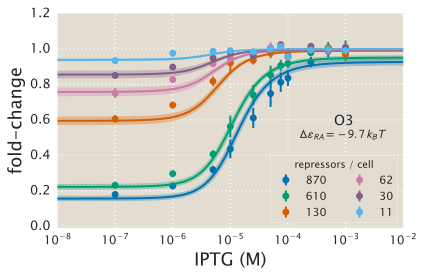

In [64]:
map_param = dict(mcmc_df_O3.mean())
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 100)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
op = 'O3'
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7}

# Initialize subplots
fig = plt.figure()
ax = plt.subplot(111)

# loop through RBS mutants
for j, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
        ea=map_param['ea'], ei=map_param['ei'], epsilon=4.5,
        R=map_param[rbs],
        epsilon_r=map_param[op]),
        color=colors[j])

    # plot 95% HPD region using the variability in the parameters
    flatchain = np.array(mcmc_df_O3[['ea', 'ei', rbs, op]])
    cred_region = mwc.mcmc_cred_reg_error_prop(IPTG * 1E6, 
        flatchain, epsilon=4.5)
    ax.fill_between(IPTG, cred_region[0,:], cred_region[1,:],
                    alpha=0.3, color=colors[j])

    # compute the mean value for each concentration
    fc_mean = df_O3[df_O3.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
    # compute the standard error of the mean
    fc_err = df_O3[df_O3.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
    np.sqrt(df_O3[df_O3.rbs==rbs].groupby('IPTG_uM').size())

    # plot the experimental df_O3
    ax.errorbar(np.sort(df_O3[df_O3.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
        yerr=fc_err, fmt='o', label=df[df.rbs==rbs].repressors.unique()[0],
        color=colors[j])
# Add operator and binding energy labels.
ax.text(0.8, 0.48, r'{0}'.format(op), transform=ax.transAxes, 
        fontsize=14)
ax.text(0.7, 0.42,
        r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
        transform=ax.transAxes, fontsize=12)

ax.set_xscale('log')
ax.set_xlabel('IPTG (M)')
ax.set_ylabel('fold-change')
ax.set_ylim([-0.01, 1.2])
ax.legend(loc=0, title='repressors / cell', fontsize=11, ncol=2)
plt.tight_layout()
